# TVB PIPELINE: constructing **Brain Network Models** from empirical MRI data
 
## The pipeline will generate structural connectomes, region-average fMRI time series and functional connectomes for simulation within The Virtual Brain

### This pipeline is based on the Apps
* thevirtualbrain/tvb-pipeline-sc:1.0 (dwMRI preprocessing, tractography)
* thevirtualbrain/tvb-pipeline-fmriprep:1.0 (fMRI preprocessing)
* thevirtualbrain/tvb_converter (structural connectome, region-wise fMRI, functional connectivity, TVB input data set)

### In this tutorial you will learn how to ...
* ...upload a BIDS data set to TVB-Pipeline JupyterHub
* ...import it into a Jupyter notebook
* ...upload it to a supercomputer via PyUnicore
* ...create and execute batch job scripts for the supercomputer that execute the pipeline
* ...download the results to the notebook
* ...from there to your computer.

### Authors / Feedback 
michael.schirner@charite.de  
petra.ritter@charite.de  

### Acknowledgments
Thank you to Paul Triebkorn for co-developing the original version of this script on Collab 1.   

Thank you to the developers of MRtrix3_Connectome (Dr. Robert Smith, Florey) [1] and fmriprep [2] for creating excellent open source software that form the basis for this workflow.   


[1] https://hub.docker.com/r/bids/mrtrix3_connectome, 
https://github.com/BIDS-Apps/MRtrix3_connectome
   
   
[2] Esteban, O., Markiewicz, C. J., Blair, R. W., Moodie, C. A., Isik, A. I., Erramuzpe, A., Kent, J. D., Goncalves, M., DuPre, E., Snyder, M., Oya, H., Ghosh, S. S., Wright, J., Durnez, J., Poldrack, R. A., & Gorgolewski, K. J. (2019). fMRIPrep: a robust preprocessing pipeline for functional MRI. Nature Methods. https://doi.org/10.1038/s41592-018-0235-4
https://hub.docker.com/r/poldracklab/fmriprep/, 
https://github.com/poldracklab/fmriprep

## 1. Create EBRAINS Collab and upload BIDS data set

1. Input data **must** be in BIDS format to run the following operations. Check out the BIDS format [here](https://bids.neuroimaging.io/) for more info. Hint: there are programs that transform data from other formats into BIDS.
2. Navigate to persisted-data folder
3. Click on the "Create a Collab" button and fill out the form.
4. Create one folder for your notebooks and one for your data (New -> Folder). In the following we will assume that you called the folders "notebooks" and "data".
6. Duplicate this Ipython notebook and move it to your newly created folder "notebooks" in your persisted notebooks folder: persisted-data/notebooks.
7. Upload your BIDS data set as a zip file into "persisted-data/data".
8. Make sure that the two folders were successfully created and that the pipeline notebook and your input data were successfully uploaded into these folders.
9. Make sure that you adapt the paths to the BIDS data set and for output data according to your new persisted folders.

In this example we uploaded the file
```
dataset.zip
```

into the folder
```
/data

```



Note that we specify two paths:
* one to the BIDS MRI input data set and
* one to the FreeSurfer license file, which we need to run fmriprep. If you do not have already a license file, you can obtain it following the instructions here: https://surfer.nmr.mgh.harvard.edu/fswiki/License

To upload the data into your personal persisted folder go to the main TVB-Pipeline JupyerHub page and click on the top-right "Upload" button. Note that you must be logged in and you must be the creator/owner of the Collab to be able to do that. Once you are in your persisted folder, use the buttons to create the folders 'data' and 'FreeSurfer_license' (or name them however you want, just make sure the names are correct when we build the path below) and upload the zipped BIDS data set into the former and the license.txt from FreeSurfer into the latter.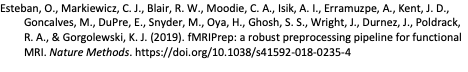

In [1]:
# get path of home folder
import os
home = os.getenv('HOME')

workspace = "pipeline"

# paths for persisted and transient drives
transient_drive = 'data'
persisted_drive = 'persisted-data'

# filename
dataset = 'dataset.zip'

# full path
full_path = os.path.join(home, workspace, transient_drive, dataset)
print(full_path)

# Freesurfer license file folder
full_fs_path = os.path.join(home, workspace, transient_drive, 'license.txt')
print(full_fs_path)

/home/jovyan/pipeline/data/dataset.zip
/home/jovyan/pipeline/data/license.txt


Let's check whether the file is really there

In [2]:
print(os.path.exists(full_path))
print(os.path.exists(full_fs_path))

True
True


If the above command returns false something went wrong. Note: you can use Bash commands like `ls` and `cd` to navigate in the file system and look for the file.

Now it's time to upload our brain model to the supercomputer. Therefore, we create a PyUnicore client.

## 3. Upload BIDS data set to supercomputer
First, we update PyUnicore, if necessary. Then, we import it. Finally, we connect with Piz Daint. To see which other supercomputers are there, and to learn their ID run the commented 
```
r.site_urls
```

To select a different supercomputer replace the supercomputer identifier string in
```
site_client = r.site('DAINT-CSCS')
```
with your preferred supercomputer.

In [3]:
# use the pyunicore library
import pyunicore.client as unicore_client

tr = unicore_client.Transport(get_token())
r = unicore_client.Registry(tr, unicore_client._HBP_REGISTRY_URL)
site_client = r.site('DAINT-CSCS')

Next, we start an "empty" interactive job to get a workspace on Piz Daint

In [4]:
job_description = {}
job = site_client.new_job(job_description)
storage = job.working_dir
#storage.properties

First, let's check the contents of the folder

In [5]:
storage.listdir()

{}

Good, it's empty. If it weren't empty we can remove files or folders with `storage.rm(filename)` or `storage.rmdir(foldername)`. Run `help(storage)` for more information.

Before uploading the BIDS ZIP file, let's look in which folder we landed on the supercomputer.

In [6]:
working_dir = (storage.properties['mountPoint']).encode('ascii')
working_dir = working_dir.decode('utf-8') # we get a "byte"-type but need a string type
working_dir

'/scratch/snx3000/unicore/FILESPACE/1fd2bf1c-438f-400a-a3fc-ab8644f679ab/'

Good. We will need the path to the working directory later.

Now, let's copy the ZIP file to the supercomputer and check whether it arrived.

In [7]:
storage.upload(input_name = full_path, destination = dataset)
storage.listdir()

{'dataset.zip': PathFile: dataset.zip}

`dataset.zip` is there -- the upload was successful.
Now we need to extract the ZIP file. We will use the program `unzip` for this task.

Now we use this client to execute the unzip command and take a quick look into the folder whether `unzip` started working.

In [8]:
exec_result = site_client.execute("unzip " + working_dir + dataset)

The execute command launches unzip and forwards the result into a new folder. Let's find out the path of the folder...

In [9]:
base_folder = exec_result.working_dir.properties['mountPoint'].encode('ascii')
wd_handle = exec_result.working_dir
base_folder = base_folder.decode('utf-8')
base_folder

'/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/'

...and its contents.

In [10]:
exec_result.working_dir.listdir()

{'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'UNICORE_SCRIPT_PID': PathFile: UNICORE_SCRIPT_PID,
 'stderr': PathFile: stderr,
 'dataset/': PathDir: dataset/,
 'stdout': PathFile: stdout,
 '__MACOSX/': PathDir: __MACOSX/}

`Unzip` worked, the folder `dataset` has been created (along with some UNICORE related output files and everything written to stdout/stderr during the command).  

## 4. Define environment variables

We have a working directory on the supercomputer and our data is there. Let's define some environment variables with important folder paths that we can use to call the BIDS Apps.

In [11]:
tvb_output = "tvb_converter_workdir"# output folder name

input_dir = base_folder + "dataset" # the name of the folder extracted from the ZIP file
output_dir = base_folder + tvb_output # full path to output folder
mrtrix_output = output_dir + "/mrtrix_output"

fmriprep_output = output_dir + "/fmriprep_output"
fmriprep_workdir = fmriprep_output + "/tmp"
tvb_output = output_dir + "/TVB_output"
tvb_workdir = tvb_output + "/tmp"

participant_label = "CON03" # BIDS <sub-XXX> keyword -- only specify XXX, not the "sub-" prefix
session_label = "postop" # BIDS <ses-XXX> keyword -- only specify XXX, not the "ses-" prefix
parcellation = "desikan" # parcellation atlas for SC and FC -- check out MRtrix3_connectome github page for available options
n_cpus = "36" # how many CPUs does your HPC node have? We'll set the number of parallel threads accordingly

task_name="ArchiSocial" # name of task fmri, as specified in the dataset

## 5. Run BIDS App `thevirtualbrain/tvb-pipeline-sc` for dwMRI preprocessing

Here we run the container `thevirtualbrain/tvb-pipeline-sc` two times on the input data. The first time it performs dwMRI preprocessing, the second time it performs the main tractography.    

The first time we run it with the command-line option "participant1", which does: DWI: Denoising; Gibbs ringing removal; motion, eddy current and EPI distortion correction and outlier detection & replacement; brain masking, bias field correction and intensity normalisation; rigid-body registration & transformation to T1-weighted image. T1-weighted image: bias field correction; brain masking.

To run the contaienr we create a SLURM batch job script for launching the `tvb-pipeline-sc` BIDS App. Instead of directly starting a job on the batch system, we use PyUnicore to submit a job on the login node, which in turn submits a job for the batch system. This gives us a greater flexibility to configure our job, we don't have to learn so much PyUnicore (although it's great!) and are failsafe if PyUnicore misses bindings for certain job managers. Note that before we run the container, we make sure that the image is up to date, or, if non-existent, gets pulled for the first time.

`sarus run <container_name>`
is the standard way of running a container. Here, we additionally use the mount command to directly mount the input and the output folders into the container's filesystem's top-level directories /input and /output.

Note that if no ```--participant_label``` and ```--session_label``` arguments are used then all subjects in all sessions will be processed. In this example we use the ```--participant_label``` argument, but not the ```--session_label``` argument. Nevertheless, output folder/file naming schemas will always depend on both ```<sub-XXX>``` and ```<ses-XXX>``` keywords (the latter only if "sessions" exist in the input data set).

For in-depth instructions for the BIDS App `tvb-pipeline-sc` please refer to the help pages of the original MRtrix3_connectome workflow at Docker Hub and Github:  
https://hub.docker.com/r/bids/mrtrix3_connectome/

https://github.com/BIDS-Apps/MRtrix3_connectome/


For an in-depth discussion of Sarus usage, check out this documentation:  
https://user.cscs.ch/tools/containers/sarus/

### Please note: There seems to be a strange bug in Sarus: sometimes the pull command   

### `srun -C mc --time=03:00:00 sarus pull thevirtualbrain/tvb-pipeline-sc:1.0`   

### works and sometimes not. It's often easier to just log into your supercomputing account via SSH and run the pull command in the shell. Once the image with the correct tag was pulled it doesn't need to be re-pulled. Sometimes the pull works if the command was issued multiple times.

In [13]:
# ADJUSTABLE PARAMETERS
################################################
wall_time = "23:59:00" # ADJUST wall time of job
job_script = "job_script"
################################################

job_script_path = os.path.join(home, workspace, transient_drive, job_script)
print(job_script_path)

# create job_script with bash commands
# this script will get forwarded to the supercomputer and there run the pipeline
with open(job_script_path, "w") as f:
    f.write("#!/bin/bash -l\n") 
    f.write("#SBATCH --time=" + wall_time + "\n")
    f.write("#SBATCH --output=slurm-" + job_script + ".out\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=1\n")    
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=" + n_cpus + "\n")
    f.write("#SBATCH --partition=normal\n")
    f.write("#SBATCH --constraint=mc\n")
    f.write("#SBATCH --hint=nomultithread\n") # disable hyperthreading such that all cores become available for multithreading
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("module load /apps/daint/UES/easybuild/modulefiles/daint-mc\n")
    f.write("module load /apps/daint/system/modulefiles/sarus/1.1.0\n\n")
    f.write("mkdir -p " + output_dir + " " + mrtrix_output + " " + fmriprep_output + " " + fmriprep_workdir + " " + tvb_output + " " + tvb_workdir + "\n\n")    
    f.write("sarus pull thevirtualbrain/tvb-pipeline-sc:1.0\n\n")
    
    f.write("srun sarus run " + 
            "--mount=type=bind,source=$HOME,target=$HOME " + 
            "--mount=type=bind,source=" + input_dir + ",target=/BIDS_dataset " +
            "--mount=type=bind,source=" + mrtrix_output + ",target=/output " +
            "thevirtualbrain/tvb-pipeline-sc:1.0 " + 
            "/BIDS_dataset /output participant1 --participant_label " + participant_label + " -skip")
    
    
#    f.write("srun sarus run " + 
#            "--mount=type=bind,source=$HOME,target=$HOME " + 
#            "--mount=type=bind,source=" + input_dir + ",target=/BIDS_dataset " +
#            "--mount=type=bind,source=" + mrtrix_output + ",target=/mrtrix3_out " +
#            "--entrypoint " + # necessary for sarus, to overwrite default entrypoint
#            "thevirtualbrain/tvb-pipeline-sc:1.0 python -c " + 
#                "\"from mrtrix3 import app; app.cleanup=False; import sys; sys.argv=" + 
#                    "'/mrtrix3_connectome.py /BIDS_dataset /mrtrix3_out participant1 " + 
#                    "--participant_label " + participant_label + " -skip "
#                    " --output_verbosity 2 --template_reg ants --n_cpus $SLURM_CPUS_PER_TASK --debug'" 
#                    ".split(); execfile('/mrtrix3_connectome.py')\"")

/home/jovyan/pipeline/data/job_script


Check the job script

In [14]:
with open(job_script_path, 'r') as fin:
    print(fin.read())

#!/bin/bash -l
#SBATCH --time=23:59:00
#SBATCH --output=slurm-job_script.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-core=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=36
#SBATCH --partition=normal
#SBATCH --constraint=mc
#SBATCH --hint=nomultithread
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
module load /apps/daint/UES/easybuild/modulefiles/daint-mc
module load /apps/daint/system/modulefiles/sarus/1.1.0

mkdir -p /scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir /scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/mrtrix_output /scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/fmriprep_output /scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/fmriprep_output/tmp /scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/TVB_output /scratch/snx3000/unicore/FILESPACE/01d7d4ef

Looking good!

## 6. Upload SLURM script to supercomputer

Here we use the same upload function as used previously for the brain model data followed by a quick check whether the file arrived.

In [15]:
wd_handle.upload(input_name=job_script_path, destination = job_script)
wd_handle.listdir()

{'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'UNICORE_SCRIPT_PID': PathFile: UNICORE_SCRIPT_PID,
 'stderr': PathFile: stderr,
 'job_script': PathFile: job_script,
 'dataset/': PathDir: dataset/,
 'stdout': PathFile: stdout,
 '__MACOSX/': PathDir: __MACOSX/}

If a file with the name stored in the variable `job_script` exists, the upload worked.

## 7. Launching step 1 of thevirtualbrain/tvb-pipeline-sc on the supercomputer

Now we will run the first out of the three BIDS Apps: mrtrix3_connectome.  
We do this by executing the the SLURM command `sbatch <job_script>`, which will evaluate our batch file and generate a job out of it that is added to the queue.
After we executed the job, we extract the working directory of this job (which will again be a new directory).

In [16]:
mrtrix_job = site_client.execute("sbatch " + base_folder + job_script)
wd_mrtrix_res = mrtrix_job.working_dir.properties['mountPoint'].encode('ascii')
wd_mrtrix_res = wd_mrtrix_res.decode('utf-8')
wd_mrtrix_res

'/scratch/snx3000/unicore/FILESPACE/9c2efbca-06e8-4b0b-adb2-70f33d4ec774/'

Note that we have two important folder handles and associated folder paths now. The following table gives an overview over handles, associated paths, and their contents.


Handle | Path variable | Description
:---: | :---: | :---:
`wd_handle` | `base_folder` | BIDS input, pipeline output
`mrtrix_job` | `wd_mrtrix_res` | SLURM job meta output


You can use the handles and path variables to access files and folders contained in the respective folders, which may be helpful, e.g. for debugging or to download other results.

## 8. Checking the result of step 1 of thevirtualbrain/tvb-pipeline-sc

The first step should run relatively quickly (~ 1h) after the job has started.
The second step however will take some time, depending on parameters like: number of generated tracks, parcellation, resolution of imaging data, number of parallel threads, etc.

Let's check whether step 1 finished successfully by inspecting the last lines of the SLURM meta output, which gives us information related to the job execution.

Note that after the job was submitted to the queue it usually takes a while until the job starts. Until then you will receive a "404 Client Error: Not found for URL" error message.

In [23]:
slurm_output = mrtrix_job.working_dir.stat("slurm-" + job_script + ".out").raw().readlines()
slurm_output[-40:]

[b'Command:  mrgrid dwi_iter2.mif crop dwi_crop.mif -mask dwi_mask_iter2.mif -uniform -3\n',
 b'Command:  mrgrid dwi_mask_iter2.mif crop mask_crop.mif -mask dwi_mask_iter2.mif -uniform -3\n',
 b'mrtrix3_connectome.py: Generating contrast-matched images for inter-modal registration between DWIs and T1\n',
 b'Command:  dwiextract dwi_crop.mif -bzero - | mrcalc - 0.0 -max - | mrmath - mean -axis 3 dwi_meanbzero.mif\n',
 b'Command:  mrcalc 1 dwi_meanbzero.mif -div mask_crop.mif -mult - | mrhistmatch nonlinear - T1.mif dwi_pseudoT1.mif -mask_input mask_crop.mif -mask_target T1_mask.mif\n',
 b'Command:  mrcalc 1 T1.mif -div T1_mask.mif -mult - | mrhistmatch nonlinear - dwi_meanbzero.mif T1_pseudobzero.mif -mask_input T1_mask.mif -mask_target mask_crop.mif\n',
 b'mrtrix3_connectome.py: Performing registration between DWIs and T1\n',
 b'Command:  mrregister dwi_pseudoT1.mif T1.mif -type rigid -mask1 mask_crop.mif -mask2 T1_mask.mif -rigid rigid_pseudoT1_to_T1.txt\n',
 b'Command:  mrregister dw

If the job finished successfully, the last few lines of the output should contain a batch job summary result, looking like this:
```
 b'mrtrix3_connectome.py: Deleting scratch directory /mrtrix3_connectome.py-tmp-MB587V/\n',
 b' \n',
 b'Batch Job Summary Report for Job "job_script" (23232141) on daint\n',
 b'-----------------------------------------------------------------------------------------------------\n',
 b'             Submit            Eligible               Start                 End    Elapsed  Timelimit \n',
 b'------------------- ------------------- ------------------- ------------------- ---------- ---------- \n',
 b'2020-06-10T13:58:04 2020-06-10T13:58:04 2020-06-10T13:58:04 2020-06-10T15:07:05   01:09:01   23:59:00 \n',
 b'-----------------------------------------------------------------------------------------------------\n',
 b'Username    Account     Partition   NNodes   Energy\n',
 b'----------  ----------  ----------  ------  --------------\n',
 b'bp000225    ich012      normal           1  589.89K joules\n',
 b' \n',
 b'This job did not utilize any GPUs\n',
 b' \n',
 b'----------------------------------------------------------\n',
 b'Scratch File System        Files       Quota\n',
 b'--------------------  ----------  ----------\n',
 b'/scratch/snx3000            6010     1000000\n',
 b' \n']
 ```
 


## 9. The second step of thevirtualbrain/tvb-pipeline-sc


After we made sure that the job finished we now run the second part of the thevirtualbrain/tvb-pipeline-sc workflow, which performs:
DWI: Response function estimation; FOD estimation. T1-weighted image (if -parcellation is not none): Tissue segmentation; grey matter parcellation. Combined (if -parcellation is not none, or -streamlines is provided): Whole-brain streamlines tractography; SIFT2; connectome construction.


#### We set the following options:

+ **--parcellation**<br>The choice of connectome parcellation scheme (compulsory for participant2-level analysis); options are: aal, aal2, brainnetome246fs, brainnetome246mni, craddock200, craddock400, desikan, destrieux, hcpmmp1, none, perry512, yeo7fs, yeo7mni, yeo17fs, yeo17mni.

+ **--participant_label**<br>The label(s) of the participant(s) that should be analyzed.

+ **-n/--n_cpus number**<br>use this number of threads in multi-threaded applications (set to 0 to disable multi-threading).



In [24]:
# ADJUSTABLE PARAMETERS
################################################
wall_time = "23:59:00" # ADJUST wall time of job
job_script = "job_script2"
################################################

job_script_path = os.path.join(home, workspace, transient_drive, job_script)
print(job_script_path)

# create job_script with bash commands
# this script will get forwarded to the supercomputer and there run the pipeline
with open(job_script_path, "w") as f:
    f.write("#!/bin/bash -l\n") 
    f.write("#SBATCH --time=" + wall_time + "\n")
    f.write("#SBATCH --output=slurm-" + job_script + ".out\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=1\n")    
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=" + n_cpus + "\n")
    f.write("#SBATCH --partition=normal\n")
    f.write("#SBATCH --constraint=mc\n")
    f.write("#SBATCH --hint=nomultithread\n") # disable hyperthreading such that all cores become available for multithreading
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("module load /apps/daint/UES/easybuild/modulefiles/daint-mc\n")
    f.write("module load /apps/daint/system/modulefiles/sarus/1.1.0\n\n")
    
    f.write("srun sarus run " + 
            "--mount=type=bind,source=$HOME,target=$HOME " + 
            "--mount=type=bind,source=" + input_dir + ",target=/BIDS_dataset " +
            "--mount=type=bind,source=" + mrtrix_output + ",target=/output " +
            "thevirtualbrain/tvb-pipeline-sc:1.0 " + 
            "/BIDS_dataset /output participant2 --parcellation desikan --n_cpus $SLURM_CPUS_PER_TASK --participant_label " + participant_label + " -skip")
    
    
with open(job_script_path, 'r') as fin:
    print(fin.read())

/home/jovyan/pipeline/data/job_script2
#!/bin/bash -l
#SBATCH --time=23:59:00
#SBATCH --output=slurm-job_script2.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-core=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=36
#SBATCH --partition=normal
#SBATCH --constraint=mc
#SBATCH --hint=nomultithread
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
module load /apps/daint/UES/easybuild/modulefiles/daint-mc
module load /apps/daint/system/modulefiles/sarus/1.1.0

srun sarus run --mount=type=bind,source=$HOME,target=$HOME --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/dataset,target=/BIDS_dataset --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/mrtrix_output,target=/output thevirtualbrain/tvb-pipeline-sc:1.0 /BIDS_dataset /output participant2 --parcellation desikan --n_cpus $SLURM_CPUS_PER_TASK --participant_label CON03 -skip


### Upload the script...

In [25]:
wd_handle.upload(input_name=job_script_path, destination = job_script)
wd_handle.listdir()

{'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'UNICORE_SCRIPT_PID': PathFile: UNICORE_SCRIPT_PID,
 'stderr': PathFile: stderr,
 'job_script': PathFile: job_script,
 'dataset/': PathDir: dataset/,
 'stdout': PathFile: stdout,
 'job_script2': PathFile: job_script2,
 '__MACOSX/': PathDir: __MACOSX/,
 'tvb_converter_workdir/': PathDir: tvb_converter_workdir/}

### ...launch it...

In [26]:
mrtrix_job2 = site_client.execute("sbatch " + base_folder + job_script)
wd_mrtrix_res2 = mrtrix_job2.working_dir.properties['mountPoint'].encode('ascii')
wd_mrtrix_res2 = wd_mrtrix_res2.decode('utf-8')
wd_mrtrix_res2

'/scratch/snx3000/unicore/FILESPACE/8957b17c-c203-4968-bda6-af4f69f4e9d1/'

Handle | Path variable | Description
:---: | :---: | :---:
`wd_handle` | `base_folder` | BIDS input, pipeline output
`mrtrix_job` | `wd_mrtrix_res` | SLURM job meta output SC 1st part
`mrtrix_job2` | `wd_mrtrix_res2` | SLURM job meta output SC 2nd part

### ...and check results.

In [39]:
slurm_output = mrtrix_job2.working_dir.stat("slurm-" + job_script + ".out").raw().readlines()
slurm_output[-40:]

[b'Command:  tck2connectome tractogram.tck parc.mif meanlength.csv -tck_weights_in weights.csv -scale_length -stat_edge mean\n',
 b'mrtrix3_connectome.py: Processing for session "sub-CON03_ses-postop" completed; writing results to output directory\n',
 b"Function: os.makedirs('/output/sub-CON03/ses-postop/connectome')\n",
 b"Function: os.makedirs('/output/sub-CON03/ses-postop/tractogram')\n",
 b'Command:  mrconvert T1.mif /output/sub-CON03/ses-postop/anat/sub-CON03_ses-postop_desc-preproc_T1w.nii.gz  -strides +1,+2,+3 -clear_property comments\n',
 b"Function: shutil.copyfile('meanlength.csv', '/output/sub-CON03/ses-postop/connectome/sub-CON03_ses-postop_desc-desikan_meanlength.csv')\n",
 b"Function: shutil.copyfile('T1.json', '/output/sub-CON03/ses-postop/anat/sub-CON03_ses-postop_desc-preproc_T1w.json')\n",
 b"Function: shutil.copyfile('connectome.csv', '/output/sub-CON03/ses-postop/connectome/sub-CON03_ses-postop_desc-desikan_level-participant_connectome.csv')\n",
 b"Function: shutil

### checking the result

It took 36 cores 03:36:54 hrs to run the second part of the tractography pipeline, but that number varies in dependence of many factors, like the used data set and the number of tracks produced.

Next, we will build a path to the folder where MRtrix stored the resulting connectome in tvb-processing-sc step 2 and have a look inside the folder.

The path to the connectome folder depends on the BIDS sub-id of the subject and -- if used -- the BIDS ses-id of the session.

In [40]:
# Path to MRtrix output connectome
connectome_folder = "tvb_converter_workdir/mrtrix_output/sub-" + participant_label + "/ses-" + session_label + "/connectome"
SC_folder = wd_handle.stat(connectome_folder)

This looks like the typical `recon-all` output folder schema. Nice!  

## 10. Upload FreeSurfer license file

What we need to do now, in order to finally preprocess the fMRI data, is to upload a FreeSurfer license file. Many will already obtained a FreeSurfer license while downloading/installing FreeSurfer. It is usually located in the FreeSurfer main folder and called  For more information on how to obtain a FreeSurfer license file, see:  

https://surfer.nmr.mgh.harvard.edu/fswiki/License

Note: the mrtrix3_connectome container already contains a FreeSurfer license, but it is a person-specific license from the container developer, so to be compliant with Usage Terms, please generate and upload your own license file as outlines in the next step.

So you generated your license file. Let's upload it. To upload, we perform the same operations as we did to upload the MRI data.

In [41]:
# upload into base_folder
wd_handle.upload(input_name = full_fs_path, destination = 'license.txt')
wd_handle.listdir()
# create file path
fs_license = base_folder + "license.txt"

## 11. Run `thevirtualbrain/tvb-pipeline-fmriprep` for fMRI preprocessing

Ok, everything is in place, let's create a batch file for `fmriprep`, which performs fMRI preprocessing.

In [42]:
# ADJUSTABLE PARAMETERS
################################################
job_script_fmriprep = "job_script_fmriprep" # name of the job script file
wall_time = "23:59:00"
aroma_melodic_dimensionality = "-120"
################################################

with open(job_script_fmriprep, "w") as f:
    f.write("#!/bin/bash -l\n")  
    f.write("#SBATCH --time=" + wall_time + "\n")
    f.write("#SBATCH --output=slurm-" + job_script_fmriprep + ".out\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=1\n")    
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=" + n_cpus + "\n")
    f.write("#SBATCH --partition=normal\n")
    f.write("#SBATCH --constraint=mc\n")
    f.write("#SBATCH --hint=nomultithread\n") # disable hyperthreading such that all cores become available for multithreading
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("module load /apps/daint/UES/easybuild/modulefiles/daint-mc\n")
    f.write("module load /apps/daint/system/modulefiles/sarus/1.1.0\n\n")
    f.write("sarus pull thevirtualbrain/tvb-pipeline-fmriprep\n")
    f.write("srun sarus run " + 
            "--mount=type=bind,source=$HOME,destination=$HOME " +
            "--mount=type=bind,source=" + input_dir + ",destination=/dataset " +
            "--mount=type=bind,source=" + fmriprep_output + ",destination=/fmriprep_out/ " +
            "--mount=type=bind,source=" + fmriprep_workdir + ",destination=/fmriprep_workdir/ " +
            "--mount=type=bind,source=" + fs_license + ",destination=/license.txt " +
            "thevirtualbrain/tvb-pipeline-fmriprep " +
            "/dataset /fmriprep_out/ participant " +
            "--use-aroma --bold2t1w-dof 6 --nthreads $SLURM_CPUS_PER_TASK " +
            "--omp-nthreads $SLURM_CPUS_PER_TASK " +
            "--output-spaces T1w MNI152NLin6Asym:res-2 fsaverage5 " +
            "--participant_label " + participant_label + " " +
            "--fs-license-file /license.txt " +
            "--aroma-melodic-dimensionality " + aroma_melodic_dimensionality + " " +
            "-w /fmriprep_workdir\n")

Check whether it looks good

In [43]:
!cat job_script_fmriprep

#!/bin/bash -l
#SBATCH --time=23:59:00
#SBATCH --output=slurm-job_script_fmriprep.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-core=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=36
#SBATCH --partition=normal
#SBATCH --constraint=mc
#SBATCH --hint=nomultithread
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
module load /apps/daint/UES/easybuild/modulefiles/daint-mc
module load /apps/daint/system/modulefiles/sarus/1.1.0

sarus pull thevirtualbrain/tvb-pipeline-fmriprep
srun sarus run --mount=type=bind,source=$HOME,destination=$HOME --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/dataset,destination=/dataset --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/fmriprep_output,destination=/fmriprep_out/ --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/fmriprep_output/tmp,destination=/fmriprep_workdir/ --m

Upload it

In [44]:
wd_handle.upload(input_name=job_script_fmriprep, destination = job_script_fmriprep)
wd_handle.listdir()

{'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'UNICORE_SCRIPT_PID': PathFile: UNICORE_SCRIPT_PID,
 'stderr': PathFile: stderr,
 'license.txt': PathFile: license.txt,
 'job_script': PathFile: job_script,
 'dataset/': PathDir: dataset/,
 'job_script_fmriprep': PathFile: job_script_fmriprep,
 'stdout': PathFile: stdout,
 'job_script2': PathFile: job_script2,
 '__MACOSX/': PathDir: __MACOSX/,
 'tvb_converter_workdir/': PathDir: tvb_converter_workdir/}

The file `job_script_fmriprep` is there, upload worked. Time to submit the batch job to the queue.

In [45]:
fmriprep_job = site_client.execute("sbatch " + base_folder + job_script_fmriprep)
wd_fmriprep = fmriprep_job.working_dir.properties['mountPoint'].encode('ascii')
wd_fmriprep

b'/scratch/snx3000/unicore/FILESPACE/eccd54c4-0449-41e7-aac1-99f47aa31f61/'

Let me just update the table to give us a better overview over handles/folders.

Handle | Path variable | Description
:---: | :---: | :---:
`wd_handle` | `base_folder` | BIDS input, pipeline output
`mrtrix_job` | `wd_mrtrix_res` | SLURM job meta output SC 1st part
`mrtrix_job2` | `wd_mrtrix_res2` | SLURM job meta output SC 2nd part
`fmriprep_job` | `wd_fmriprep` | SLURM job meta output fmriprep


Now let's check whether fmriprep is (still) running or finished.

# Please note: There seems to be a strange bug in Sarus: sometimes the command   

# `srun sarus pull thevirtualbrain/tvb-pipeline-fmriprep`   

# works and sometimes not. It's often easier to just log into your supercomputing account via SSH and run the pull command in the shell. Once the container with the "latest" tag was pulled it doesn't need to be re-pulled.

In [53]:
slurm_output = fmriprep_job.working_dir.stat("slurm-" + job_script_fmriprep + ".out").raw().readlines()
slurm_output[-40:]

[b'200824-23:58:56,436 nipype.workflow INFO:\n',
 b'\t [Node] Running "ica_aroma_confound_extraction" ("fmriprep.interfaces.confounds.ICAConfounds")\n',
 b'200824-23:58:56,446 nipype.workflow INFO:\n',
 b'\t [Node] Finished "fmriprep_wf.single_subject_CON03_wf.func_preproc_ses_postop_task_rest_wf.ica_aroma_wf.add_nonsteady".\n',
 b'200824-23:58:56,492 nipype.workflow INFO:\n',
 b'\t [Node] Finished "fmriprep_wf.single_subject_CON03_wf.func_preproc_ses_postop_task_rest_wf.ica_aroma_wf.ica_aroma_confound_extraction".\n',
 b'200824-23:59:24,721 nipype.workflow INFO:\n',
 b'\t [Node] Setting-up "fmriprep_wf.single_subject_CON03_wf.func_preproc_ses_postop_task_rest_wf.ica_aroma_wf.ica_aroma_metadata_fmt" in "/fmriprep_workdir/fmriprep_wf/single_subject_CON03_wf/func_preproc_ses_postop_task_rest_wf/ica_aroma_wf/ica_aroma_metadata_fmt".\n',
 b'200824-23:59:24,747 nipype.workflow INFO:\n',
 b'\t [Node] Running "ica_aroma_metadata_fmt" ("niworkflows.interfaces.utils.TSV2JSON")\n',
 b'200824-23:

You know the drill: unless there is the job summary at the end, the job hasn't finished.

## 12. Select `recon-all` output

Either of the two Apps, `mrtrix3_connectome` and `fmriprep`, may have run `recon-all` (depending on which parcellation you have chosen). Here, we set the appropriate folder. In this example we used the parcellation `desikan` and `mrtrix3_connectome` generated `recon_all` output which we re-used later in `fmriprep`. So let's configure accordingly. Below are the two alternatives in different cells, choose only one.

In [55]:
# Option 1: recon_all run by fmriprep
recon_all_dir = base_folder + "tvb_converter_workdir/fmriprep_output/freesurfer"
recon_all_subject_name = "sub-" + participant_label
print(recon_all_dir)
print(recon_all_subject_name)

/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/fmriprep_output/freesurfer
sub-CON03


In [56]:
# Option 2: recon_all run by MRtrix3
recon_all_dir = base_folder + freesurfer_path[:-10] # cut-off the last "freesurfer"
recon_all_subject_name = "freesurfer"

NameError: name 'freesurfer_path' is not defined

In [57]:
recon_all_dir

'/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir/fmriprep_output/freesurfer'

## 13. Run BIDS App `tvb_converter` to generate TVB input

What remains to be done is to create a batch file for the tvb_converter BIDS App, upload it and execute it.

In [58]:
# ADJUSTABLE PARAMETERS
################################################
wall_time = "01:00:00"
cpu_per_task = "36"
job_script_tvb_conv = "job_script_tvb_conv" # name of the job script file
################################################

# FIXED PARAMETERS
################################################
weights_path = "/mrtrix3_out/sub-" + participant_label + "/connectome/sub-" + participant_label + "_parc-" + parcellation + "_level-participant_connectome.csv"
tracts_path = "/mrtrix3_out/sub-" + participant_label + "/connectome/sub-" + participant_label + "_parc-"+ parcellation+ "_meanlength.csv"
################################################


with open(job_script_tvb_conv, "w") as f:
    f.write("#!/bin/bash -l\n")  
    f.write("#SBATCH --time=" + wall_time + "\n")
    f.write("#SBATCH --output=slurm-" + job_script_tvb_conv + ".out\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=1\n")    
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=" + cpu_per_task + "\n")
    f.write("#SBATCH --partition=normal\n")
    f.write("#SBATCH --constraint=mc\n")
    f.write("#SBATCH --hint=nomultithread\n") # disable hyperthreading such that all cores become available for multithreading
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("module load /apps/daint/UES/easybuild/modulefiles/daint-mc\n")
    f.write("module load /apps/daint/system/modulefiles/sarus/1.1.0\n\n")
    f.write("sarus pull thevirtualbrain/tvb-pipeline-converter:1.0\n")
    f.write("srun sarus run " +
            "--mount=type=bind,source=`dirname " + fs_license + "`,destination=/freesurfer_license_dir/ " + 
            "--mount=type=bind,source=" + input_dir + ",destination=/input_dir " +
            "--mount=type=bind,source=" + output_dir + ",destination=/output_dir " +
            "--mount=type=bind,source=" + mrtrix_output + ",destination=/mrtrix3_out " +
            "--mount=type=bind,source=" + fmriprep_output + ",destination=/fmriprep_out " +
            "--mount=type=bind,source=" + fmriprep_workdir + ",destination=/fmriprep_workdir " +
            "--mount=type=bind,source=" + tvb_output + ",destination=/tvb_out " +
            "--mount=type=bind,source=" + tvb_workdir + ",destination=/tvb_workdir " +
            "--mount=type=bind,source=" + recon_all_dir + ",destination=/recon_all_dir " +
            "--entrypoint thevirtualbrain/tvb-pipeline-converter:1.0 " +
            "/bin/bash -c \"cp /freesurfer_license_dir/license.txt /opt/freesurfer/ && " +
                            "mkdir -p /recon_all_dir/" + recon_all_subject_name + "/bem && " +
                            "cd /recon_all_dir/" + recon_all_subject_name + "/bem && " +
                            "/tvb_converter_pipeline.sh /input_dir /output_dir /mrtrix3_out /fmriprep_out " +
                            "/fmriprep_workdir /tvb_out /tvb_workdir /recon_all_dir " + recon_all_subject_name + " " +
                            participant_label + " " + task_name + " " + parcellation + " " + weights_path + 
                            " " + tracts_path + " " + cpu_per_task + "\"\n")

Check it

In [59]:
!cat job_script_tvb_conv

#!/bin/bash -l
#SBATCH --time=01:00:00
#SBATCH --output=slurm-job_script_tvb_conv.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-core=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=36
#SBATCH --partition=normal
#SBATCH --constraint=mc
#SBATCH --hint=nomultithread
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
module load /apps/daint/UES/easybuild/modulefiles/daint-mc
module load /apps/daint/system/modulefiles/sarus/1.1.0

sarus pull thevirtualbrain/tvb-pipeline-converter:1.0
srun sarus run --mount=type=bind,source=`dirname /scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/license.txt`,destination=/freesurfer_license_dir/ --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/dataset,destination=/input_dir --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480-9d72-070a2c1975fc/tvb_converter_workdir,destination=/output_dir --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/01d7d4ef-6a79-4480

Upload it

In [60]:
wd_handle.upload(input_name=job_script_tvb_conv, destination = job_script_tvb_conv)
wd_handle.listdir()

{'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'UNICORE_SCRIPT_PID': PathFile: UNICORE_SCRIPT_PID,
 'stderr': PathFile: stderr,
 'license.txt': PathFile: license.txt,
 'job_script': PathFile: job_script,
 'dataset/': PathDir: dataset/,
 'job_script_fmriprep': PathFile: job_script_fmriprep,
 'job_script_tvb_conv': PathFile: job_script_tvb_conv,
 'stdout': PathFile: stdout,
 'job_script2': PathFile: job_script2,
 '__MACOSX/': PathDir: __MACOSX/,
 'tvb_converter_workdir/': PathDir: tvb_converter_workdir/}

The file is there, upload worked. Time to submit the batch job to the queue.

In [65]:
tvb_conv_job = site_client.execute("sbatch " + base_folder + job_script_tvb_conv)
wd_tvb_conv = tvb_conv_job.working_dir.properties['mountPoint'].encode('ascii')
wd_tvb_conv

b'/scratch/snx3000/unicore/FILESPACE/fcd13f78-2ca6-4e0d-9908-0825224dcbe5/'

Let's update the table one last time

Handle | Path variable | Description
:---: | :---: | :---:
`wd_handle` | `base_folder` | BIDS input, pipeline output
`mrtrix_job` | `wd_mrtrix_res` | SLURM job meta output MRtrix3
`fmriprep_job` | `wd_fmriprep` | SLURM job meta output fmriprep
`tvb_conv_job` | `wd_tvb_conv` | SLURM job meta output tvb_converter


Let's check whether tvb_converter is (still) running or finished.

In [69]:
slurm_output = tvb_conv_job.working_dir.stat("slurm-" + job_script_tvb_conv + ".out").raw().readlines()
slurm_output[-40:]

[b'\n',
 b'\n',
 b'Image Exception : #22 :: ERROR: Could not open image /fmriprep_out/fmriprep/sub-CON03/func/sub-CON03_task-ArchiSocial_space-T1w_boldref\n',
 b"terminate called after throwing an instance of 'RBD_COMMON::BaseException'\n",
 b'/tvb_converter_pipeline.sh: line 40:   592 Aborted                 (core dumped) flirt -in ${mrtrix_output}/sub-${participant_label}/anat/sub-${participant_label}_parc-${parcellation}_indices.nii.gz -out ${mrtrix_output}/sub-${participant_label}/anat/sub-${participant_label}_parc-${parcellation}_indices_resample2bold.nii.gz -ref ${fmriprep_output}/fmriprep/sub-${participant_label}/func/sub-${participant_label}_task-${task_name}_space-T1w_boldref.nii.gz -nosearch -interp nearestneighbour\n',
 b'Extract fmri ROI timeseries\n',
 b'Image Exception : #22 :: ERROR: Could not open image /fmriprep_out/fmriprep/sub-CON03/func/sub-CON03_task-ArchiSocial_space-T1w_AromaNonAggressiveDenoised\n',
 b"terminate called after throwing an instance of 'RBD_COMMON::

## 14. Download TVB ready data

 On the supercomputer, results are stored in the folder
```
<tvb_output>
```

If everything went smoothly, there will be nine files in this folder:  

```
sub-<participant_label>_task-rest_parc-desikan_ROI_timeseries.txt
sub-<participant_label>_EEGProjection.mat
sub-<participant_label>_region_mapping.txt
sub-<participant_label>_inner_skull_surface.zip
sub-<participant_label>_Cortex.zip
sub-<participant_label>_outer_skull_surface.zip
sub-<participant_label>_outer_skin_surface.zip
sub-<participant_label>_EEG_Locations.txt
sub-<participant_label>_Connectome.zip
```

We will go on to zip the folder and download the results to the Docker image filesystem in which the Jupyter notebook client is running. 



In [72]:
wd_handle.listdir()

{'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'UNICORE_SCRIPT_PID': PathFile: UNICORE_SCRIPT_PID,
 'stderr': PathFile: stderr,
 'license.txt': PathFile: license.txt,
 'job_script': PathFile: job_script,
 'dataset/': PathDir: dataset/,
 'job_script_fmriprep': PathFile: job_script_fmriprep,
 'job_script_tvb_conv': PathFile: job_script_tvb_conv,
 'stdout': PathFile: stdout,
 'job_script2': PathFile: job_script2,
 '__MACOSX/': PathDir: __MACOSX/,
 'tvb_converter_workdir/': PathDir: tvb_converter_workdir/}

In [73]:
site_client.execute("zip -r " + tvb_output+".zip " + tvb_output)
output_hdl = wd_handle.stat("tvb_converter_workdir/TVB_output.zip")
output_hdl.download("TVB_output.zip")

All that is left to do is to move the TVB_output.zip file to the persisted-data/data folder if you want this archive to be persisted or you can download it by checking the checkbox and hitting the "Download" button.

Additionally the created derivatives for TVB are stored in BIDS format inside the dataset provided at the beginning.
We will now zip and download this one too. 

# 15. Download pipeline output in BIDS format

The pipeline results are also stored according to the BIDS specifications inside the /derivatives/TVB directory of the given BIDS folder. 
The data are stored following the specifications of the Common derivatives and Computational models BIDS extension proposal. <br><br>

Common derivatives <br>
https://docs.google.com/document/d/1Wwc4A6Mow4ZPPszDIWfCUCRNstn7d_zzaWPcfcHmgI4/edit <br>
<br>
Computational models <br>
https://docs.google.com/document/d/1oaBWmkrUqH28oQb1PTO-rG_kuwNX9KqAoE9i5iDh1xw/edit#heading=h.mqkmyp254xh6 <br>
<br>

What remains is to zip, download the BIDS folder from the HPC and to add a additional dataset_description.json to the /derivatives directory to comply with BIDS


In [75]:
# zip the BIDS folder on the HPC
site_client.execute("cd " + base_folder + " && zip -r " + dataset + " " 
                    + dataset.strip(".zip"))

# download the BIDS folder
output_hdl = wd_handle.stat(dataset)
output_hdl.download(dataset)

# unzip 
import zipfile
with zipfile.ZipFile(dataset, 'r') as zip_ref:
    zip_ref.extractall("./")

In [77]:
# generate BIDS-compliant metadata file dataset_description.json

import json
from collections import OrderedDict


# Arguments
input_dataset_description_json = dataset.strip(".zip")+'/dataset_description.json'
output_dataset_description_json = dataset.strip(".zip")+'/dataset_description.json'


# 1 read the dataset_description.json from the raw data set 
with open(input_dataset_description_json, "r") as input_json:
    data = json.load(input_json)


# 2 prepend "TVB pipeline derivative: " to the value of the key "Name" 
# to indicate that this is not the original raw data set, but
# a derivative generated by the TVB pipeline.
data['Name'] = "TVB pipeline derivative: " + data['Name'] 


## Uncomment below to generate the data dict from scratch
#data= OrderedDict()
#data['Name'] = ''
#data['BIDSVersion'] = '1.0.2'
#data['License'] = ''
#data['Authors'] = ['','','']
#data['HowToAcknowledge'] = ''
#data['Funding'] = ['','','']
#data['ReferencesAndLinks'] = ['','','']
#data['DatasetDOI'] = ''


# 3 Add fields for BIDS derivatives
data['PipelineDescription'] = {
    	"Name": "TVB", # REQUIRED: this field must be a substring of the folder name of the pipeline output
        "Version": "1.0", 
    	"CodeURL": "https://github.com/BrainModes",
    	"DockerHubContainerTag": "thevirtualbrain/tvb_pipeline",
    	"SingularityContainerURL": "",
    	"SingularityContainerVersion": "" 
    }

data['SourceDatasets'] = [
    	{
    		"URL": "",
    		"DOI": data['DatasetDOI'],
    		"Version": ""
    	}
#    	,{
#    		"URL": "",
#    		"DOI": "",
#    		"Version": ""
#    	}    
    ]


# 4 Save JSON
with open(output_dataset_description_json, 'w') as ff:
    json.dump(data, ff,sort_keys=False, indent=4)

In [57]:
ls -l dataset/

In [58]:
# zip the BIDS folder
shutil.make_archive(dataset.strip(".zip"), 'zip', dataset.strip(".zip"))

'/home/jovyan/BIDS_test.zip'

In [59]:
# and download to the collab storage
collab_storage.upload_file(dataset, COLLAB_PATH+"/BIDS_TVB_derivatives.zip")

'521f92bb-1c6c-4dd9-907d-8a225ca914ae'

# Integration with HBP Knowledgegraph

To integrate the produced pipeline output into KnowledgeGraph, the user is required to provide values for MINDS metadata keys. The provided metadata is stored in the file minds_metadata.json in order to be read out by the curation team. <br>
<br>
Please read through the following lines of code and enter applicable information.

In [60]:
# generate MINDS-compliant metadata file minds_metadata.json

# Arguments
output_MINDS_JSON = 'minds_metadata.json'

# Pipeline users are requested to fill out the following fields
# in order to integrate data with KnowledgeGraph
# Enter the information between the ""
Dataset__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
Dataset__has_contributor = "" # enter corresponding Person block _ID 
Dataset_created_as = "" # choose: HBP-SGA1, HBP-SGA2, HBP-SGA3, external 
Dataset__has_custodian = "" # enter corresponding Person block _ID 
Dataset_description = "" # describe the content of this metadata block 
Dataset_DOI = "" # if this dataset already has a DOI, please enter it here (otherwise a DOI will be assigned to this dataset when it is released 
Dataset_embargo_status = "" # choose: embargoed, not-embargoed 
Dataset_intended_release_date = "" # if you chose "embargoed" please state here the intended release date (format: yyyy-mm-dd) 
Dataset_license = "" # enter the data license, choose (e.g.) from Creative Comments licence list 
Dataset__has_main_contact = "" # enter corresponding Person block _ID 
Dataset__has_main_file_bundle = "" # enter the corresponding FileBundle block _ID 
Dataset_title = "" # enter a meaningful title for this metadata block 
EthicsApproval__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
EthicsApproval_authority = "" # enter the ethics authority name of this ethics approval 
EthicsApproval_country = "" # enter the country of this ethics approval was issued 
EthicsApproval_ID = "" # enter the received identifier of this ethics approval 
EthicsApproval_SP12_approval = "" # choose: yes, no 
File__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
File_description = "" # describe the content of this metadata block 
File_format = "" # enter format of file of this File block 
File_title = "" # enter a meaningful title for this metadata block 
File_URL = "" # enter URL to file of this File block 
FileBundle__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
FileBundle_description = "" # describe the content of this metadata block 
FileBundle_format = "" # enter format of file occurring in this FileBundle block 
FileBundle_tag = "" # enter tag for grouping reason 
FileBundle_title = "" # enter a meaningful title for this metadata block 
FileBundle_URL = "" # enter URL to the file-folder or URLs to corresponding files belonging to this FileBundle block (multiple entries as multiple rows) 
FundingInformation__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
FundingInformation_grant_ID = "" # enter identification number of the grant of this FundingInformation block  
FundingInformation_name = "" # enter name of funding institution of this FundingInformation block  
MethodParadigm__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
MethodParadigm_abbreviation = "" # enter abbreviated name of instance described in this metadata block 
MethodParadigm_description = "" # describe the content of this metadata block 
MethodParadigm_experimental_type = "" # choose: in vivo, ex vivo, in utero, in vitro, in situ, in silico 
MethodParadigm_full_name = "" # enter full name of instance described in this metadata block 
MethodParadigm_type = "" # enter high level type to which the method/paradigm of this Method/Paradigm block belongs to (e.g., imaging, behavioral assay) 
ModelInstance__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
ModelInstance__is_modelling_sub_cellular_target = "" # enter corresponding StudyTarget block _ID 
ModelInstance_abstraction_level = "" # choose: protein structure, systems biology, spiking neurons, rate neurons, population modelling, cognitive modelling or enter other abstraction level 
ModelInstance_alias = "" # enter alternative name for this metadata block  
ModelInstance__is_modelling_brain_structure = "" # enter corresponding StudyTarget block _ID 
ModelInstance__has_contributor = "" # enter corresponding Person block _ID 
ModelInstance__has_custodian = "" # enter corresponding Person block _ID 
ModelInstance_description = "" # describe content of this metadata block 
ModelInstance__has_main_contact = "" # enter corresponding Person block _ID 
ModelInstance_model_format = "" # choose: NeuroML, PyNN, SONATA, NEURON-Python, NEURON-Hoc, NEST-SLI, NEST-PYTHON, Java, C++, C, Brian, NineML, MATLAB, NetPyNE 
ModelInstance_model_format_version_compatibility = "" # enter which model format version is compatible for the model of this ModelInstant block 
ModelInstance_model_scope = "" # choose: subcellular model (spine, ion channel, signalling, or molecular), single cell model, network model (microcircuit, brain region, or whole brain) or enter other model scope 
ModelInstance_species = "" # enter binomial name of species used for this ModelInstant (e.g., Homo sapiens, Mus musculus, Rattus norvegicus, Macaca mulatta, Macaca fascicularis) 
ModelInstance_title = "" # enter a meaningful title for this metadata block 
ModelInstance_version = "" # enter version number for model described in this ModelInstance 
Person__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
Person_email = "" # if no ORCID, please enter email of this Person 
Person_first_name = "" # if no ORCID, please enter first name of this Person 
Person_last_name = "" # if no ORCID, please enter last name of this Person 
Person_ORCID = "" # if available, enter ORCID of this Person 
PLAComponent__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
PLAComponent_associated_task_ID = "" # enter identifier of associated HBP task for corresponding PLA component 
PLAComponent_ID = "" # enter identifier of corresponding PLA component 
PLAComponent__has_owner = "" # enter corresponding Person block _ID 
PLAComponent_phase = "" # enter HBP project phase of corresponding PLA component (e.g., HBP-SGA1) 
Project__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
Project__has_coordinator = "" # enter corresponding Person block_ID 
Project_description = "" # describe the content of this metadata block 
Project_title = "" # enter a meaningful title for this metadata block 
PublicationResource__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
PublicationResource_ID = "" # enter identifier of corresponding publication/resource 
PublicationResource_ID_type = "" # choose: DOI, ISSN, ISBN, URL, or other identifier type 
StudyTarget__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
StudyTarget_abbreviation = "" # enter abbreviated name of instance described in this metadata block 
StudyTarget_full_name = "" # enter full name of instance described in this metadata block 
StudyTarget_source_of_name = "" # if full name is chosen from a terminology or ontology, enter name of corresponding terminology or ontology list 
StudyTarget_type = "" # choose: disease, disease model, tissue type, brain structure, cell type, subcellular structure, macromolecular complex, biological process 
Subject__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
Subject_age = "" # enter age of subject described in this Subject block 
Subject_age_category = "" # choose: embryo, neonate, juvenile, young adult, adult, aged adult 
Subject_age_range_max = "" # within in the time frame of the experiment, enter maximum age of subject described in this Subject block 
Subject_age_range_min = "" # within in the time frame of the experiment, enter minimum age of subject described in this Subject block 
Subject_alias = "" # enter alternative name for this metadata block  
Subject_disabilitydisease = "" # enter disability, disease or disease model the subject of this Subject block has  
Subject_genotype = "" # enter genotype of the subject described in this Subject block 
Subject_handedness = "" # choose: left, right, ambidextrous 
Subject_sex = "" # choose: female, male, hermaphrodite 
Subject_species = "" # enter binomial species name of this Subject (e.g., Homo sapiens, Mus musculus, Rattus norvegicus, Macaca mulatta, Macaca fascicularis) 
Subject_strain = "" # enter strain of the subject described in this Subject block 
SubjectGroup__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
SubjectGroup_age_category = "" # choose: embryo, neonate, juvenile, young adult, adult, aged adult 
SubjectGroup_age_range_max = "" # within in the time frame of the experiment, enter maximum age of subject described in this Subject block 
SubjectGroup_age_range_min = "" # within in the time frame of the experiment, enter minimum age of subject described in this Subject block 
SubjectGroup_alias = "" # enter alternative name for this metadata block  
SubjectGroup_description = "" # describe content of this metadata block 
SubjectGroup_disabilitydisease = "" # enter disability, disease or disease model the subjects connected to this SubjectGroup block have  
SubjectGroup_genotype = "" # enter genotype of subjects connected to this SubjectGroup block 
SubjectGroup_handedness = "" # choose: left, right, ambidextrous 
SubjectGroup_number_of_subjects = "" # enter number of subjects connected to this SubjectGroup block
SubjectGroup_sex = "" # choose: female, male, hermaphrodite 
SubjectGroup_species = "" # enter binomial name of species occurring in this SubjectGroup (e.g., Homo sapiens, Mus musculus, Rattus norvegicus, Macaca mulatta, Macaca fascicularis) 
SubjectGroup_strain = "" # enter strain of subjects connected to this SubjectGroup block 
TissueSample__ID = "" # enter your unique identifier for this metadata block, will later be replaced by a system (Knowledge Graph) wide unique identifier 
TissueSample_alias = "" # enter alternative name for this metadata block  
TissueSample_hemisphere = "" # choose: left, right 
TissueSample_pathology = "" # enter pathology state of tissue described in this TissueSample block 
TissueSample_type = "" # choose: whole brain, hemisphere, slice, brain part, cortical column, or enter other tissue sample type 

##################################################
# Create MINDS JSON object
import json
from collections import OrderedDict

data = OrderedDict()

data['Dataset'] = [
    	{
    		"_ID": Dataset__ID,
    		"_has_contributor": Dataset__has_contributor,
    		"created as": Dataset_created_as,
            "_has_custodian": Dataset__has_custodian,
    		"description": Dataset_description,
    		"DOI": Dataset_DOI,
            "embargo status": Dataset_embargo_status,
    		"intended release date": Dataset_intended_release_date,
    		"license": Dataset_license,
            "_has_main_contact": Dataset__has_main_contact,
    		"_has_main_file_bundle": Dataset__has_main_file_bundle,
    		"title": Dataset_title
    	}  
    ]

data['EthicsApproval'] = [
    	{
    		"_ID": EthicsApproval__ID,
    		"authority": EthicsApproval_authority,
    		"country": EthicsApproval_country,
            "ID": EthicsApproval_ID,
    		"SP12 approval": EthicsApproval_SP12_approval
    	}  
    ]

data['File'] = [
    	{
    		"_ID": File__ID,
    		"description": File_description,
    		"format": File_format,
            "title": File_title,
    		"URL": File_URL
    	}  
    ]

data['FileBundle'] = [
    	{
    		"_ID": FileBundle__ID,
    		"description": FileBundle_description,
    		"format": FileBundle_format,
            "tag": FileBundle_tag,
    		"title": FileBundle_title,
    		"URL": FileBundle_URL
    	}  
    ]

data['FundingInformation'] = [
    	{
    		"_ID": FundingInformation__ID,
    		"grant ID": FundingInformation_grant_ID,
    		"name": FundingInformation_name
    	}  
    ]

data['Method/Paradigm'] = [
    	{
    		"_ID": MethodParadigm__ID,
    		"abbreviation": MethodParadigm_abbreviation,
    		"description": MethodParadigm_description,
            "experimental type": MethodParadigm_experimental_type,
    		"full name": MethodParadigm_full_name,
            "type": MethodParadigm_type
    	}  
    ]

data['ModelInstance'] = [
    	{
    		"_ID": ModelInstance__ID,
    		"_is_modelling_sub_cellular_target": ModelInstance__is_modelling_sub_cellular_target,
    		"abstraction level": ModelInstance_abstraction_level,
    		"alias": ModelInstance_alias,
            "_is_modelling_brain_structure": ModelInstance__is_modelling_brain_structure,
    		"_has_contributor": ModelInstance__has_contributor,
            "_has_custodian": ModelInstance__has_custodian,
            "description": ModelInstance_description,
    		"_has_main_contact": ModelInstance__has_main_contact,
    		"model format": ModelInstance_model_format,
    		"model format version compatibility": ModelInstance_model_format_version_compatibility,
            "model scope": ModelInstance_model_scope,
    		"species":ModelInstance_species,
    		"title": ModelInstance_title,
            "version": ModelInstance_version
    	}  
    ]


data['Person'] = [
    	{
    		"_ID": Person__ID,
    		"email": Person_email,
    		"first name": Person_first_name,
            "last name": Person_last_name,
    		"ORCID": Person_ORCID
    	}  
    ]

data['PLAComponent'] = [
    	{
    		"_ID": PLAComponent__ID,
    		"associated task (ID)": PLAComponent_associated_task_ID,
    		"ID": PLAComponent_ID,
            "_has_owner": PLAComponent__has_owner,
    		"phase": PLAComponent_phase
    	}  
    ]


data['Project'] = [
    	{
    		"_ID": Project__ID,
    		"_has_coordinator": Project__has_coordinator,
    		"description": Project_description,
            "title": Project_title
    	}  
    ]

data['Publication/Resource'] = [
    	{
    		"_ID": PublicationResource__ID,
    		"ID": PublicationResource_ID,
    		"ID type": PublicationResource_ID_type
    	}  
    ]


data['StudyTarget'] = [
    	{
    		"_ID": StudyTarget__ID,
    		"abbreviation": StudyTarget_abbreviation,
    		"full name": StudyTarget_full_name,
            "source of name": StudyTarget_source_of_name,
    		"type": StudyTarget_type
    	}  
    ]



data['Subject'] = [
    	{
    		"_ID": Subject__ID,
    		"age": Subject_age,
    		"age category": Subject_age_category,
    		"age range (max)": Subject_age_range_max,
            "age range (min)": Subject_age_range_min,
    		"alias": Subject_alias,
            "disability/disease": Subject_disabilitydisease,
            "genotype": Subject_genotype,
    		"handedness": Subject_handedness,
    		"sex": Subject_sex,
    		"species": Subject_species,
            "strain": Subject_strain
    	}  
    ]

data['SubjectGroup'] = [
    	{
    		"_ID": SubjectGroup__ID,
    		"age category": SubjectGroup_age_category,
    		"age range (max)": SubjectGroup_age_range_max,
            "age range (min)": SubjectGroup_age_range_min,
    		"alias": SubjectGroup_alias,
    		"description": SubjectGroup_description,
            "disability/disease": SubjectGroup_disabilitydisease,
            "genotype": SubjectGroup_genotype,
    		"handedness": SubjectGroup_handedness,
    		"number of subjects": SubjectGroup_handedness,
    		"sex": SubjectGroup_sex,
    		"species": SubjectGroup_species,
            "strain": SubjectGroup_strain
    	}  
    ]

data['TissueSample'] = [
    	{
    		"_ID": TissueSample__ID,
    		"alias": TissueSample_alias,
    		"hemisphere": TissueSample_hemisphere,
            "pathology": TissueSample_pathology,
            "type": TissueSample_type
    	}  
    ]


# Save JSON
with open(output_MINDS_JSON, 'w') as ff:
    json.dump(data, ff,sort_keys=False, indent=4)

In [61]:
# load the minds_metadata.json to HBP Collab storage
collab_storage.upload_file(output_MINDS_JSON, COLLAB_PATH+"/"+output_MINDS_JSON)

'70ce6cd9-4b4c-4f85-9006-8e07a9b4cfef'